In [59]:
import numpy as np
import sympy as sp
import pandas as pd
import math
import matplotlib.pyplot as plt


from sympy import solve, Eq, symbols, re

#NOTE - Anytime skew is used in this code, it refers to 3rd moment


def split_by_plus_minus(s):
    return s.str.split(r'[\+\-]', expand=True)[0]

IAT_params = pd.read_csv('IATparameters_kurt_variation_extended.csv')
IAT_params[['lam1', 'lam2']] = IAT_params[['lam1', 'lam2']].apply(lambda x: x.str.split("+").str[0])
IAT_params[['lam1', 'lam2']] = IAT_params[['lam1', 'lam2']].apply(lambda x: x.str.split("-").str[0])
IAT_params[['lam1', 'lam2']] = IAT_params[['lam1', 'lam2']].astype(float)
print(IAT_params.head())
print(IAT_params.dtypes)




ST_params = pd.read_csv('STparameters_kurt_variation_extended.csv')
ST_params[['mu1', 'mu2']] = ST_params[['mu1', 'mu2']].apply(lambda x: x.str.split("+").str[0])
ST_params[['mu1', 'mu2']] = ST_params[['mu1', 'mu2']].apply(lambda x: x.str.split("-").str[0])
ST_params[['mu1', 'mu2']] = ST_params[['mu1', 'mu2']].astype(float)
print(ST_params.head())
print(ST_params.dtypes)

          p      lam1      lam2  kurt
0  0.513508  0.036907  0.021025   0.5
1  0.540537  0.053306  0.005670   0.5
2  0.473390  0.013513  0.044795   0.5
3  0.479670  0.017098  0.040999   0.5
4  0.523179  0.042718  0.015468   0.5
p       float64
lam1    float64
lam2    float64
kurt    float64
dtype: object
          q       mu1       mu2  kurt
0  0.491932  0.060452  0.084170   0.5
1  0.479220  0.042099  0.103177   0.5
2  0.525978  0.111028  0.034682   0.5
3  0.478770  0.041455  0.103854   0.5
4  0.462534  0.018467  0.128544   0.5
q       float64
mu1     float64
mu2     float64
kurt    float64
dtype: object


In [60]:
def calculatecoeff_var(lam1, lam2, p) :
    dist_mean =  p/lam1+ (1-p)/lam2
    dist_var = (2*p/lam1**2 + 2*(1-p)/lam2**2) - dist_mean**2
    dist_sd = abs(np.sqrt(dist_var))
    
    if (dist_sd / dist_mean) >= 1 :
        return(dist_sd/dist_mean)
    else :
        print("Please check your inputs. Coefficient of variance < 1")
        return -100

In [68]:
def Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr) :
    WTarasov_arr = []
    
    
    mu_CV_arr = []
    lam_CV_arr = []
    for k2 in range( len(q_arr)) : 
        for k1 in range( len(p_arr)) : 
            
            if calculatecoeff_var(lam1_arr[k1], lam2_arr[k1], p_arr[k1]) >=1 : 
                lam_CV_arr.append(calculatecoeff_var(lam1_arr[k1], lam2_arr[k1], p_arr[k1]))
            
            if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :
                mu_CV_arr.append(calculatecoeff_var(mu1_arr[k2], mu2_arr[k2], q_arr[k2]))
            else :
                continue
                
            a_0 = (lam1_arr[k1]*lam2_arr[k1])
            a_1 = p_arr[k1]*lam1_arr[k1] + (1-p_arr[k1])*lam2_arr[k1]
            b_0 = (mu1_arr[k2]*mu2_arr[k2])
            b_1 = q_arr[k2]*mu1_arr[k2] + (1-q_arr[k2])*mu2_arr[k2]

            c_0 = a_0*b_1 - a_1*b_0 - a_0*(mu1_arr[k2]+mu2_arr[k2]) + b_0*(lam1_arr[k1] + lam2_arr[k1])
            c_1 = -a_1*b_1 -a_0 - b_0  + (lam1_arr[k1] + lam2_arr[k1])*(mu1_arr[k2] + mu2_arr[k2])
            c_2 = lam1_arr[k1] + lam2_arr[k1] - mu1_arr[k2] - mu2_arr[k2]

            x = symbols('x')
            expr = x**3-c_2*x**2-c_1*x-c_0


            sol = solve(expr)
            #print(sol)

            #calculate wait time in queue Wq

            Wq = (-1/re(sol[0])) + (-1/re(sol[1])) - (1/mu1_arr[k2]) - (1/mu2_arr[k2]) 

            #calculate response time in queue W

            W = Wq + (q_arr[k2]/mu1_arr[k2]+ (1-q_arr[k2])/mu2_arr[k2])
            WTarasov_arr.append(abs(W))
            
        if len(WTarasov_arr) > 5000 :
            break
    
    
        

    return WTarasov_arr, lam_CV_arr, mu_CV_arr

In [38]:
#Now we fix 3 moments of IAT (that is I give in p, lam1, lam2), for ST move ahead with fixed mean and kurtosis

#Using M/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())
#p_arr = [0.531]*10
p_arr = [1]*10
lam1_arr = [0.0216]*10
lam2_arr = [0.015]*10




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= []
    mu1_arr = []
    mu2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    ST_params_filtered = ST_params[ST_params['kurt'] == moment4]
    print('ST DF', ST_params_filtered.head())
    q_arr = ST_params_filtered['q'].tolist()
    mu1_arr = ST_params_filtered['mu1'].tolist()
    mu2_arr = ST_params_filtered['mu2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    print("CV of IAT", lam_CV_arr[0])
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [1.5] * len(W_exact),
                            'mu_kurt' : [moment4] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 25, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 2.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 25, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 20 :
        W_exact = (np.array(W_exact)) * + 10
        plt.scatter(mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 2.5, Kurts = 20')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 25 :
        W_exact = (np.array(W_exact)) *   10
        plt.scatter(mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 25, Kurts = 25')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 25, Kurts = 0.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    plt.legend()

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsM_H2_1_fixedmeanKurt.csv', index= True)

Lengths for parameter vectors of IAT :  10 10 10
For Kurtosis 0.5
ST DF           q       mu1       mu2  kurt
0  0.491932  0.060452  0.084170   0.5
1  0.479220  0.042099  0.103177   0.5
2  0.525978  0.111028  0.034682   0.5
3  0.478770  0.041455  0.103854   0.5
4  0.462534  0.018467  0.128544   0.5
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 

Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Coefficient of variance < 1
Please check your inputs. Co

KeyboardInterrupt: 

<Figure size 576x576 with 0 Axes>

Lengths for parameter vectors of ST :  10 10 10
For Kurtosis 0.5
IAT DF           p      lam1      lam2  kurt
0  0.513508  0.036907  0.021025   0.5
1  0.540537  0.053306  0.005670   0.5
2  0.473390  0.013513  0.044795   0.5
3  0.479670  0.017098  0.040999   0.5
4  0.523179  0.042718  0.015468   0.5
CV of IAT 1.0000000000000002
Lengths for parameter vectors of IAT :  71 71 71
Lengths for parameter vectors of ST :  10 10 10
Length of IAT and ST CV , W vectors 710 710 710
False
False
For Kurtosis 1.5
IAT DF            p      lam1      lam2  kurt
71  0.478855  0.005680  0.031312   1.5
72  0.523951  0.033064  0.004033   1.5
73  0.475745  0.003855  0.033254   1.5
74  0.469153  0.000013  0.037395   1.5
75  0.504782  0.021220  0.015422   1.5
CV of IAT 1.0000000000000002
Lengths for parameter vectors of IAT :  39 39 39
Lengths for parameter vectors of ST :  10 10 10
Length of IAT and ST CV , W vectors 390 390 390
False
False
For Kurtosis 2.5
IAT DF             p      lam1      lam2  kurt
110  0

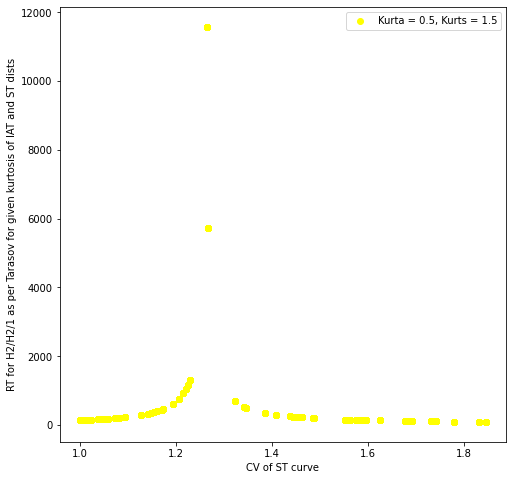

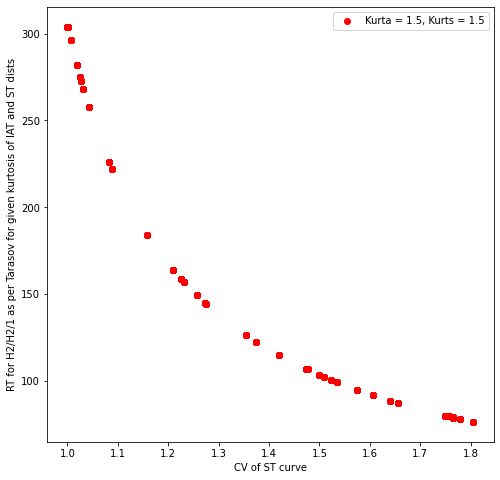

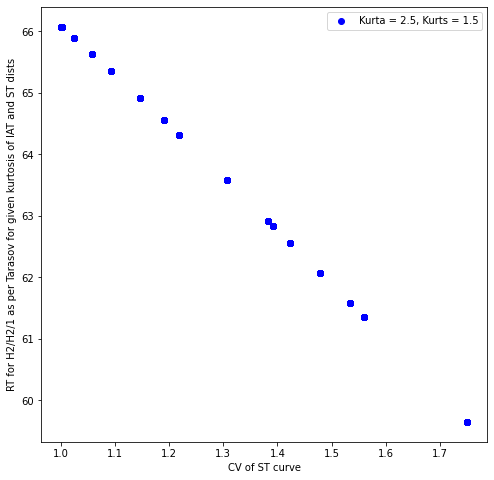

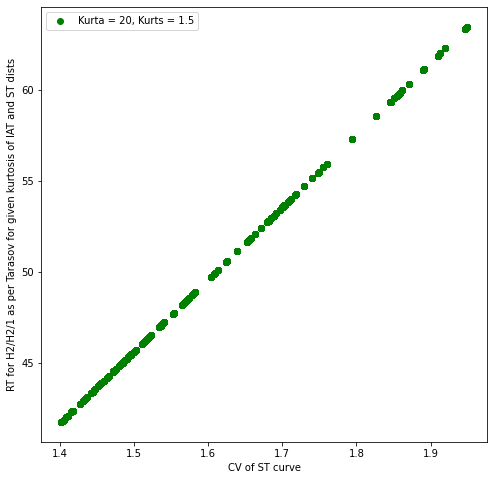

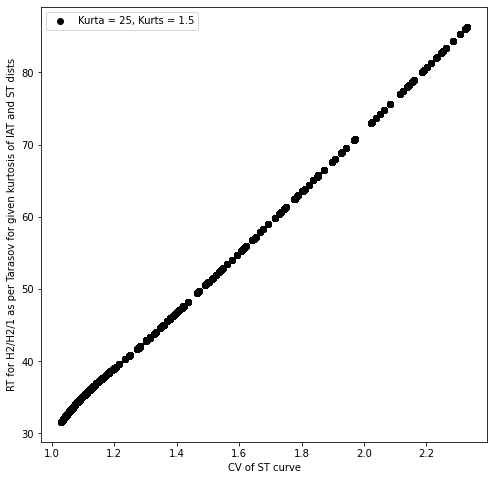

In [37]:
#Now we fix 3 moments of IAT (that is I give in q, mu1, mu2), for ST move ahead with fixed mean and kurtosis

#Using H2/M/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())
#p_arr = [0.531]*10
q_arr = [1]*10
mu1_arr = [0.0216]*10
mu2_arr = [0.015]*10


final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    IAT_params_filtered = IAT_params[IAT_params['kurt'] == moment4]
    print('IAT DF', IAT_params_filtered.head())
    p_arr = IAT_params_filtered['p'].tolist()
    lam1_arr = IAT_params_filtered['lam1'].tolist()
    lam2_arr = IAT_params_filtered['lam2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    print("CV of IAT", mu_CV_arr[0])
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr_sq = np.round(np.square(lam_CV_arr), 3)
    mu_CV_arr_sq = np.round(np.square(mu_CV_arr), 3)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [moment4] * len(W_exact),
                            'mu_kurt' : [1.5] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for H2/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 2.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'blue', label = 'Kurta = 2.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for H2/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 20 :
        W_exact = (np.array(W_exact)) *  10
        plt.scatter(lam_CV_arr, W_exact, color = 'green', label = 'Kurta = 20, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for H2/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 25 :
        W_exact = (np.array(W_exact)) *  10
        plt.scatter(lam_CV_arr, W_exact, color = 'black', label = 'Kurta = 25, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for H2/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(lam_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 0.5, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for H2/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
    plt.legend()

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsH2_M_1_fixedmeanKurt.csv', index= True)

IAT DF             p      lam1      lam2  kurt
251  0.695867  9.921044  0.125165  25.0
252  0.304210  0.511700  0.330344  25.0
253  0.407136  0.591229  0.302900  25.0
254  0.661793  2.526392  0.151117  25.0
255  0.383097  0.571836  0.309625  25.0
Lengths for parameter vectors of IAT :  1 1 1
For Kurtosis 0.5
ST DF           q       mu1       mu2  kurt
0  0.491932  0.060452  0.084170   0.5
1  0.479220  0.042099  0.103177   0.5
2  0.525978  0.111028  0.034682   0.5
3  0.478770  0.041455  0.103854   0.5
4  0.462534  0.018467  0.128544   0.5
Lengths for parameter vectors of IAT :  1 1 1
Lengths for parameter vectors of ST :  74 74 74
Length of IAT and ST CV , W vectors 74 74 74
False
False
lam_CV_arr 74
mu_CV 74
lam_CVsq 74
mu_CVsq 74
mu_kurt 1
Response time 74
For Kurtosis 1.5
ST DF            q       mu1       mu2  kurt
74  0.523576  0.082073  0.010631   1.5
75  0.508643  0.058954  0.032758   1.5
76  0.479668  0.015398  0.077012   1.5
77  0.480803  0.017070  0.075247   1.5
78  0.470052  

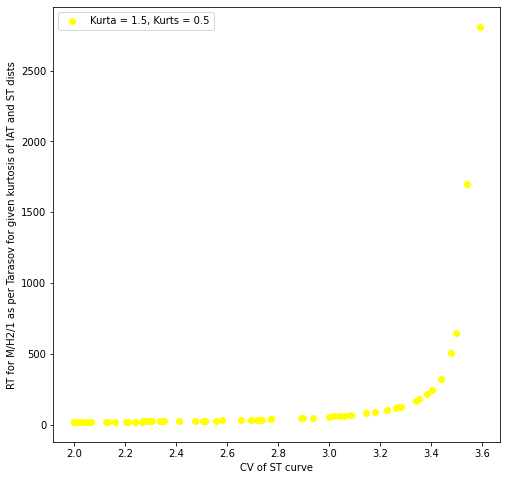

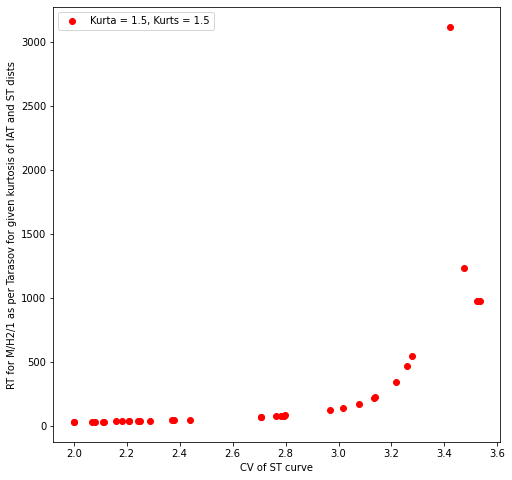

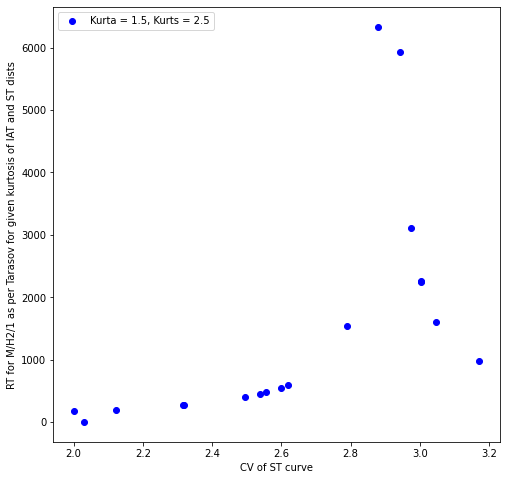

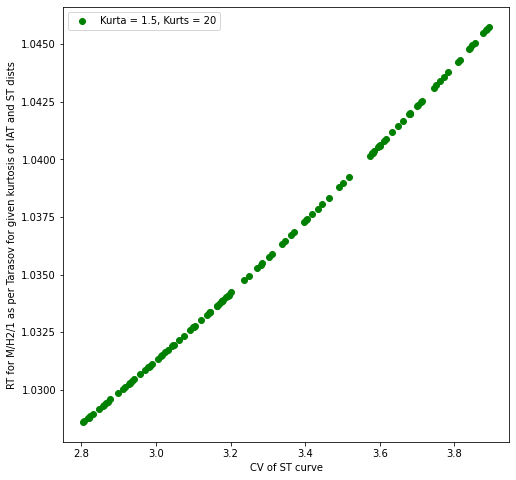

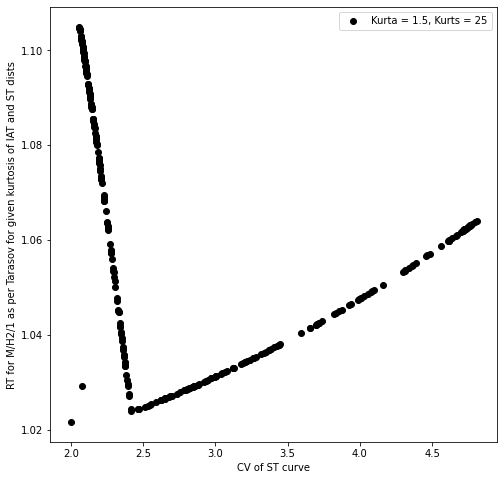

In [78]:


#Using H2/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())

p_arr = [0.5239]
lam1_arr = [0.03306]
lam2_arr = [0.00403]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
print('IAT DF', IAT_params_filtered.head())
#p_arr = IAT_params_filtered['p'].tolist()
#lam1_arr = IAT_params_filtered['lam1'].tolist()
#lam2_arr = IAT_params_filtered['lam2'].tolist()




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= []
    mu1_arr = []
    mu2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    ST_params_filtered = ST_params[ST_params['kurt'] == moment4]
    print('ST DF', ST_params_filtered.head())
    q_arr = ST_params_filtered['q'].tolist()
    mu1_arr = ST_params_filtered['mu1'].tolist()
    mu2_arr = ST_params_filtered['mu2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [1.5] * len(W_exact),
                            'mu_kurt' : [moment4] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 2.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 20 :
        #W_exact = (np.array(W_exact)) * + 10
        plt.scatter(mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 25 :
        #W_exact = (np.array(W_exact)) *   10
        plt.scatter(mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 0.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    plt.legend()
    final_df = final_df.append(store_df, ignore_index = True)

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsH2_H2_1_fixedmeanKurt_1.5Kurta_copy.csv', index= True)

IAT DF             p      lam1      lam2  kurt
251  0.695867  9.921044  0.125165  25.0
252  0.304210  0.511700  0.330344  25.0
253  0.407136  0.591229  0.302900  25.0
254  0.661793  2.526392  0.151117  25.0
255  0.383097  0.571836  0.309625  25.0
Lengths for parameter vectors of IAT :  1 1 1
For Kurtosis 0.5
ST DF           q       mu1       mu2  kurt
0  0.491932  0.060452  0.084170   0.5
1  0.479220  0.042099  0.103177   0.5
2  0.525978  0.111028  0.034682   0.5
3  0.478770  0.041455  0.103854   0.5
4  0.462534  0.018467  0.128544   0.5
Lengths for parameter vectors of IAT :  1 1 1
Lengths for parameter vectors of ST :  74 74 74
Length of IAT and ST CV , W vectors 295 295 295
False
False
lam_CV_arr 74
mu_CV 74
lam_CVsq 74
mu_CVsq 74
mu_kurt 1
Response time 74
For Kurtosis 1.5
ST DF            q       mu1       mu2  kurt
74  0.523576  0.082073  0.010631   1.5
75  0.508643  0.058954  0.032758   1.5
76  0.479668  0.015398  0.077012   1.5
77  0.480803  0.017070  0.075247   1.5
78  0.47005

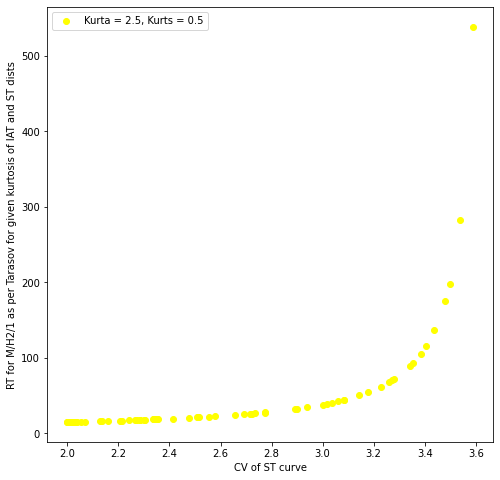

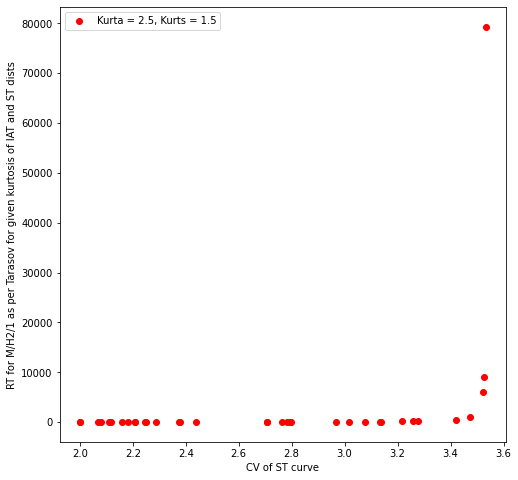

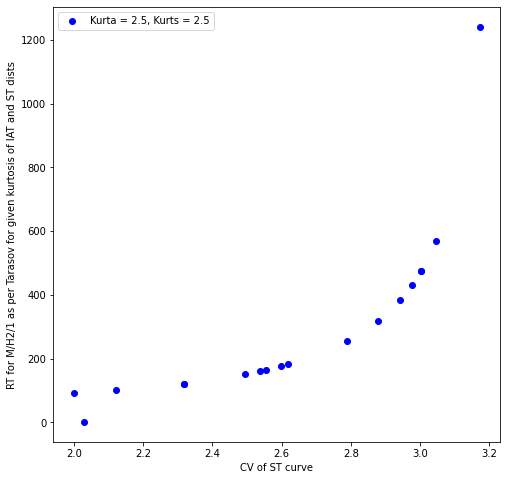

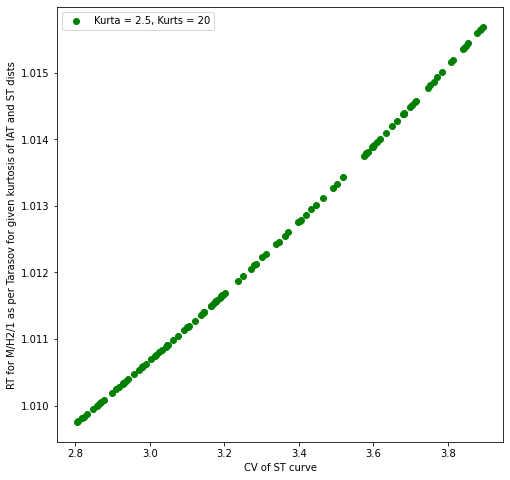

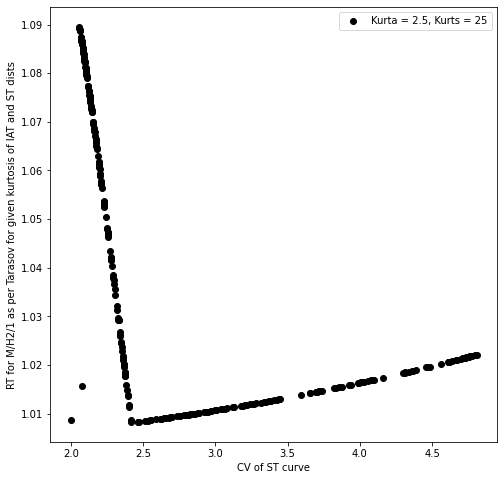

In [77]:


#Using H2/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())

p_arr = [0.4921]
lam1_arr = [0.00155]
lam2_arr = [0.01143]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 2.5]
print('IAT DF', IAT_params_filtered.head())
#p_arr = IAT_params_filtered['p'].tolist()
#lam1_arr = IAT_params_filtered['lam1'].tolist()
#lam2_arr = IAT_params_filtered['lam2'].tolist()




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= []
    mu1_arr = []
    mu2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    ST_params_filtered = ST_params[ST_params['kurt'] == moment4]
    print('ST DF', ST_params_filtered.head())
    q_arr = ST_params_filtered['q'].tolist()
    mu1_arr = ST_params_filtered['mu1'].tolist()
    mu2_arr = ST_params_filtered['mu2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
   
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [2.5] * len(W_exact),
                            'mu_kurt' : [moment4] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 2.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 2.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 2.5, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 20 :
        #W_exact = (np.array(W_exact)) * + 10
        plt.scatter(mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 2.5, Kurts = 20')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 25 :
        #W_exact = (np.array(W_exact)) *   10
        plt.scatter(mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 2.5, Kurts = 25')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 2.5, Kurts = 0.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    plt.legend()
    final_df = final_df.append(store_df, ignore_index = True)

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()



final_df.to_csv('DetailsH2_H2_1_fixedmeanKurt_2.5Kurta_copy.csv', index= True)

IAT DF             p      lam1      lam2  kurt
251  0.695867  9.921044  0.125165  25.0
252  0.304210  0.511700  0.330344  25.0
253  0.407136  0.591229  0.302900  25.0
254  0.661793  2.526392  0.151117  25.0
255  0.383097  0.571836  0.309625  25.0
Lengths for parameter vectors of IAT :  275 275 275
For Kurtosis 0.5
ST DF           q       mu1       mu2  kurt
0  0.491932  0.060452  0.084170   0.5
1  0.479220  0.042099  0.103177   0.5
2  0.525978  0.111028  0.034682   0.5
3  0.478770  0.041455  0.103854   0.5
4  0.462534  0.018467  0.128544   0.5
Lengths for parameter vectors of IAT :  275 275 275
Lengths for parameter vectors of ST :  74 74 74
Length of IAT and ST CV , W vectors 4720 4720 4720
False
False
lam_CV_arr 5032
mu_CV 5032
lam_CVsq 5032
mu_CVsq 5032
mu_kurt 1
Response time 5032
For Kurtosis 1.5
ST DF            q       mu1       mu2  kurt
74  0.523576  0.082073  0.010631   1.5
75  0.508643  0.058954  0.032758   1.5
76  0.479668  0.015398  0.077012   1.5
77  0.480803  0.017070  0

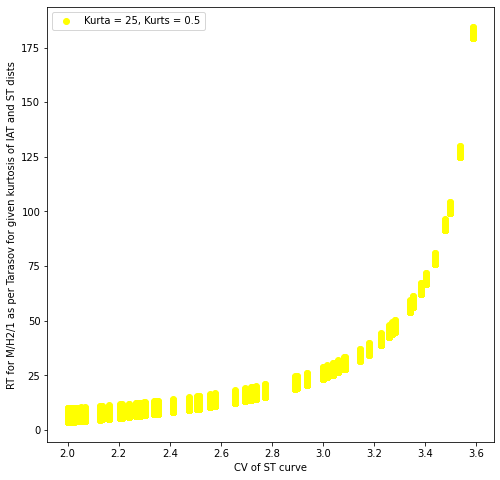

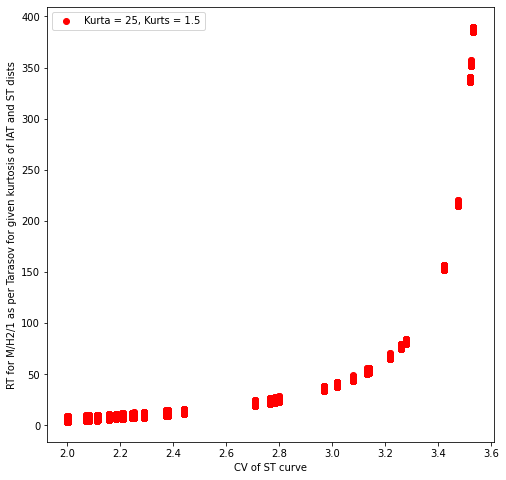

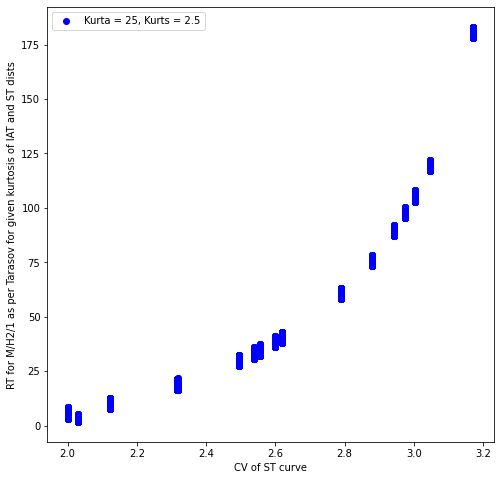

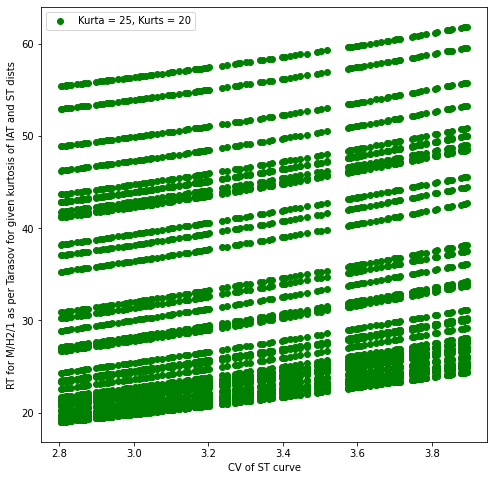

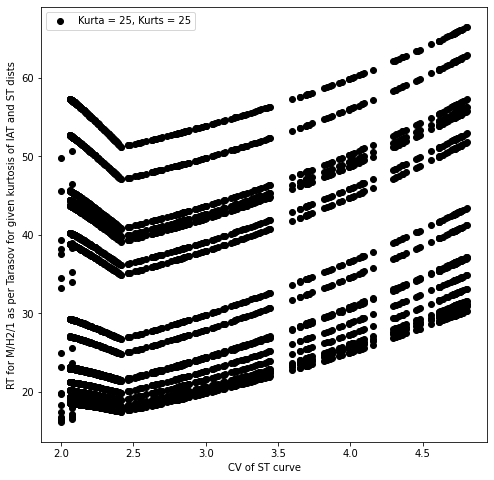

In [52]:


#Using H2/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())

#p_arr = [0.5295]*10
#lam1_arr = [0.0365712]*10
#lam2_arr = [0.000771]*10

IAT_params_filtered = IAT_params[IAT_params['kurt'] == 25]
print('IAT DF', IAT_params_filtered.head())
p_arr = IAT_params_filtered['p'].tolist()
lam1_arr = IAT_params_filtered['lam1'].tolist()
lam2_arr = IAT_params_filtered['lam2'].tolist()




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    q_arr= []
    mu1_arr = []
    mu2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    ST_params_filtered = ST_params[ST_params['kurt'] == moment4]
    print('ST DF', ST_params_filtered.head())
    q_arr = ST_params_filtered['q'].tolist()
    mu1_arr = ST_params_filtered['mu1'].tolist()
    mu2_arr = ST_params_filtered['mu2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [1.5] * len(W_exact),
                            'mu_kurt' : [moment4] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 25, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 2.5 :
        plt.scatter(mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 25, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 20 :
        W_exact = (np.array(W_exact)) * + 10
        plt.scatter(mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 25, Kurts = 20')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 25 :
        W_exact = (np.array(W_exact)) *   10
        plt.scatter(mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 25, Kurts = 25')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 25, Kurts = 0.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of ST curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    plt.legend()

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsH2_H2_1_fixedmeanKurt_25Kurta_copy.csv', index= True)

In [ ]:
Now fixing ST CV, changing IAT CV

ST DF             q       mu1       mu2  kurt
109  0.491905  0.003543  0.028951   2.5
110  0.493864  0.006584  0.025843   2.5
111  0.505768  0.025260  0.007157   2.5
112  0.494328  0.007306  0.025108   2.5
113  0.507809  0.028496  0.003987   2.5
Lengths for parameter vectors of ST :  1 1 1
For Kurtosis 0.5
IAT DF           p      lam1      lam2  kurt
0  0.513508  0.036907  0.021025   0.5
1  0.540537  0.053306  0.005670   0.5
2  0.473390  0.013513  0.044795   0.5
3  0.479670  0.017098  0.040999   0.5
4  0.523179  0.042718  0.015468   0.5
Lengths for parameter vectors of IAT :  71 71 71
Lengths for parameter vectors of ST :  1 1 1
Length of IAT and ST CV , W vectors 71 71 71
False
False
lam_CV_arr 71
mu_CV 71
lam_CVsq 71
mu_CVsq 71
mu_kurt 1
Response time 71
For Kurtosis 1.5
IAT DF            p      lam1      lam2  kurt
71  0.478855  0.005680  0.031312   1.5
72  0.523951  0.033064  0.004033   1.5
73  0.475745  0.003855  0.033254   1.5
74  0.469153  0.000013  0.037395   1.5
75  0.504782  

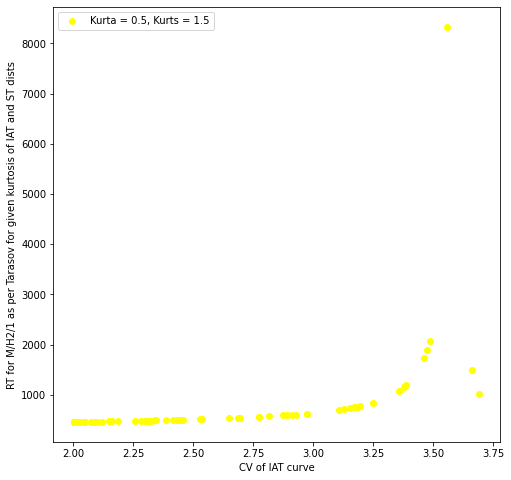

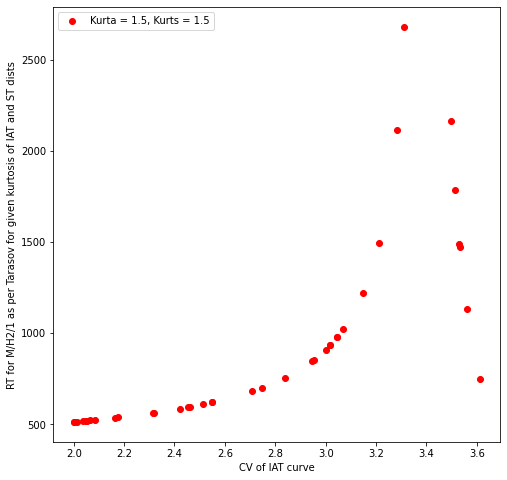

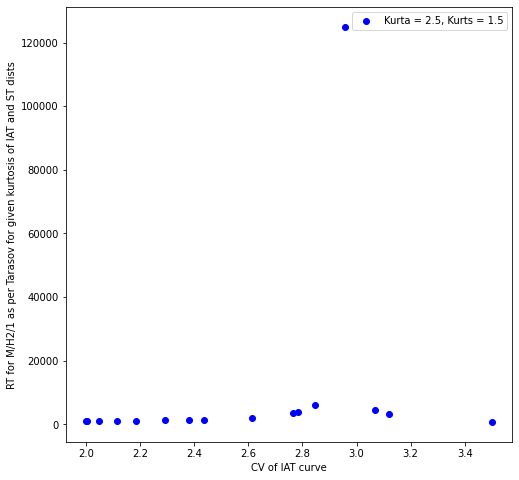

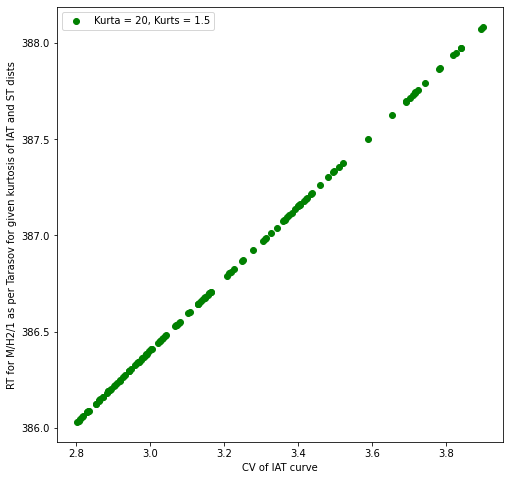

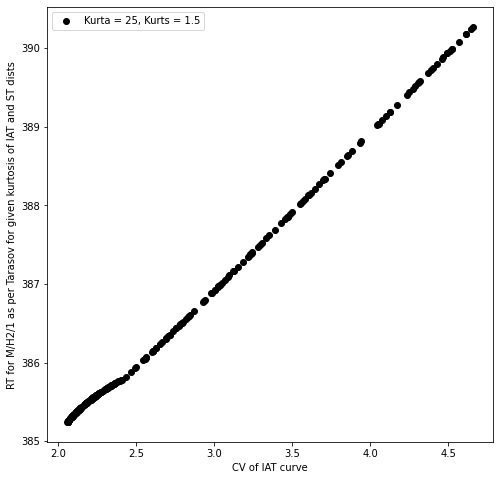

In [71]:


#Using H2/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())

q_arr = [0.47]
mu1_arr = [0.001335]
mu2_arr = [0.09207]

#ST_params_filtered = ST_params[ST_params['kurt'] == 1.5]
print('ST DF', ST_params_filtered.head())
#q_arr = ST_params_filtered['q'].tolist()
#mu1_arr = ST_params_filtered['mu1'].tolist()
#mu2_arr = ST_params_filtered['mu2'].tolist()




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    IAT_params_filtered = IAT_params[IAT_params['kurt'] == moment4]
    print('IAT DF', IAT_params_filtered.head())
    p_arr = IAT_params_filtered['p'].tolist()
    lam1_arr = IAT_params_filtered['lam1'].tolist()
    lam2_arr = IAT_params_filtered['lam2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [moment4] * len(W_exact),
                            'mu_kurt' : [1.5] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 2.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'blue', label = 'Kurta = 2.5, Kurts = 1.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 20 :
        #W_exact = (np.array(W_exact)) * + 10
        plt.scatter(lam_CV_arr, W_exact, color = 'green', label = 'Kurta = 20, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 25 :
        #W_exact = (np.array(W_exact)) *   10
        plt.scatter(lam_CV_arr, W_exact, color = 'black', label = 'Kurta = 25, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(lam_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 0.5, Kurts = 1.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    plt.legend()
    final_df = final_df.append(store_df, ignore_index = True)

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()


final_df = final_df.append(store_df, ignore_index = True)
final_df.to_csv('DetailsH2_H2_1_fixedmeanKurt_1.5Kurts.csv', index= True)

ST DF             q       mu1       mu2  kurt
109  0.491905  0.003543  0.028951   2.5
110  0.493864  0.006584  0.025843   2.5
111  0.505768  0.025260  0.007157   2.5
112  0.494328  0.007306  0.025108   2.5
113  0.507809  0.028496  0.003987   2.5
Lengths for parameter vectors of ST :  1 1 1
For Kurtosis 0.5
IAT DF           p      lam1      lam2  kurt
0  0.513508  0.036907  0.021025   0.5
1  0.540537  0.053306  0.005670   0.5
2  0.473390  0.013513  0.044795   0.5
3  0.479670  0.017098  0.040999   0.5
4  0.523179  0.042718  0.015468   0.5
Lengths for parameter vectors of IAT :  71 71 71
Lengths for parameter vectors of ST :  1 1 1
Length of IAT and ST CV , W vectors 71 71 71
False
False
lam_CV_arr 71
mu_CV 71
lam_CVsq 71
mu_CVsq 71
mu_kurt 1
Response time 71
For Kurtosis 1.5
IAT DF            p      lam1      lam2  kurt
71  0.478855  0.005680  0.031312   1.5
72  0.523951  0.033064  0.004033   1.5
73  0.475745  0.003855  0.033254   1.5
74  0.469153  0.000013  0.037395   1.5
75  0.504782  

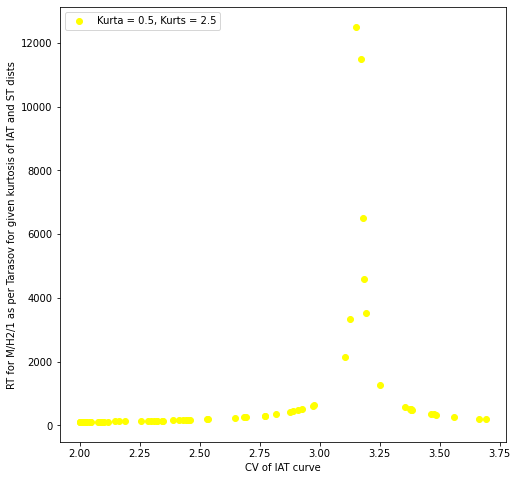

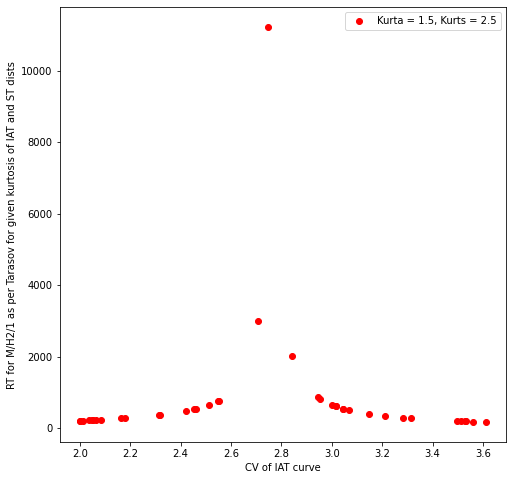

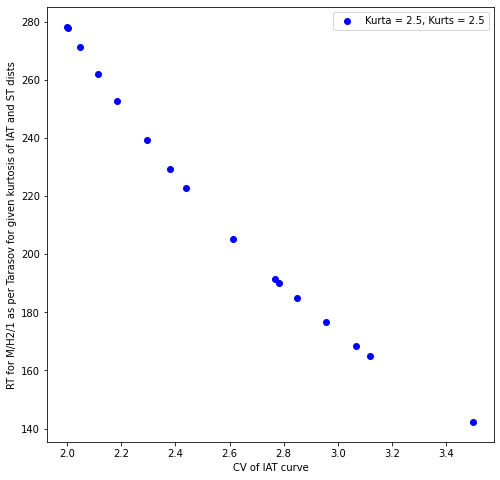

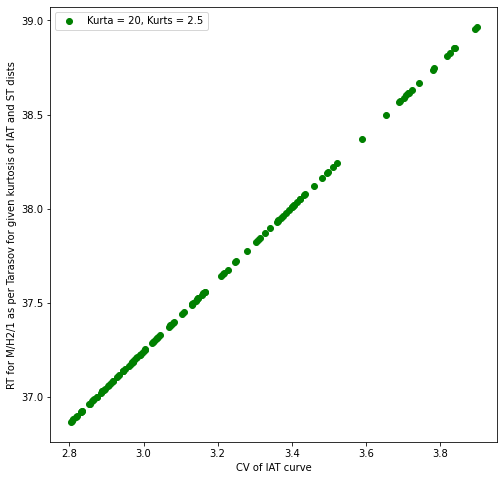

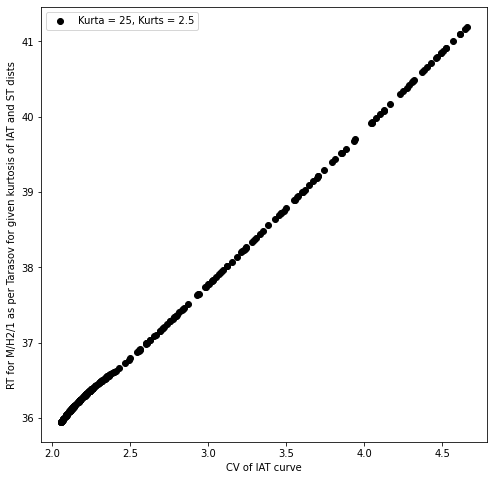

In [72]:


#Using H2/H2/1

moment4_arr = [0.5, 1.5, 2.5, 20, 25]

#IAT_params_filtered = IAT_params[IAT_params['kurt'] == 1.5]
#print('IAT DF', IAT_params_filtered.head())

q_arr = [0.493]
mu1_arr = [0.00677]
mu2_arr = [0.02565]

#ST_params_filtered = ST_params[ST_params['kurt'] == 2.5]
print('ST DF', ST_params_filtered.head())
#q_arr = ST_params_filtered['q'].tolist()
#mu1_arr = ST_params_filtered['mu1'].tolist()
#mu2_arr = ST_params_filtered['mu2'].tolist()




final_df = pd.DataFrame(columns = ['lam_CV', 'mu_CV', 'lam_CVsq', 'mu_CVsq', 'lam_kurt', 'mu_kurt', 'Response time'])

print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

for moment4 in moment4_arr : 

    print('For Kurtosis', moment4)
    i = 0
    j = 0
    #For IAT where mean service time is 5
    p_arr= []
    lam1_arr = []
    lam2_arr = []
    #mu_CV_arr = []
    

    
    #lam_CV_arr = []

    IAT_params_filtered = IAT_params[IAT_params['kurt'] == moment4]
    print('IAT DF', IAT_params_filtered.head())
    p_arr = IAT_params_filtered['p'].tolist()
    lam1_arr = IAT_params_filtered['lam1'].tolist()
    lam2_arr = IAT_params_filtered['lam2'].tolist()


    

    fig = plt.figure(figsize=(8, 8))
    #ax1 = fig.add_subplot( projection='2d')
    
    '''

    while i < len(p_arr) -1 :
        if calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]) >=1 :

            lam_CV_arr.append(calculatecoeff_var(lam1_arr[i], lam2_arr[i], p_arr[i]))
        else :
            lam1_arr.remove(lam1_arr[i])
            lam2_arr.remove(lam2_arr[i])
            p_arr.remove(p_arr[i])
        i += 1

    while j < len(q_arr) -1 :


        if calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]) >=1 :

            mu_CV_arr.append(calculatecoeff_var(mu1_arr[j], mu2_arr[j], q_arr[j]))
        else :
            mu1_arr.remove(mu1_arr[j])
            mu2_arr.remove(mu2_arr[j])
            q_arr.remove(q_arr[j])
        j += 1


    
   
    if len(p_arr) < len(q_arr) :
        q_arr = q_arr[:len(p_arr)] 
        mu1_arr = mu1_arr[:len(p_arr)]
        mu2_arr = mu2_arr[:len(p_arr)]
        mu_CV_arr = mu_CV_arr [:len(p_arr)]

    else :
        p_arr = p_arr[:len(q_arr)]
        lam1_arr = lam1_arr[:len(q_arr)]
        lam2_arr = lam2_arr[:len(q_arr)]
        lam_CV_arr = lam_CV_arr[:len(q_arr)]
   
    '''
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    
    print("Lengths for parameter vectors of IAT : ", len(p_arr), len(lam1_arr), len(lam2_arr))
    print("Lengths for parameter vectors of ST : ", len(q_arr), len(mu1_arr), len(mu2_arr))

    print('Length of IAT and ST CV , W vectors', len(lam_CV_arr), len(mu_CV_arr), len(W_exact))


    #print(mu_coeff_var_arr)
    W_exact, lam_CV_arr, mu_CV_arr = Tarasov(p_arr, lam1_arr, lam2_arr, q_arr, mu1_arr, mu2_arr)
    lam_CV_arr = np.array(lam_CV_arr) * 2
    lam_CV_arr_sq = np.square(lam_CV_arr)
    mu_CV_arr = np.array(mu_CV_arr) * 2
    mu_CV_arr_sq = np.square(mu_CV_arr)
    #W_exact.pop()
    print(any(num1 < 0 for num1 in W_exact))
    print(any(num2 < 0 for num2 in W_exact))
    
    #Stacking and storing them into a csv
    
    
    
    print('lam_CV_arr',len(lam_CV_arr))
    print('mu_CV', len(mu_CV_arr))
    print('lam_CVsq', len(lam_CV_arr_sq))
    print('mu_CVsq', len(mu_CV_arr_sq))
   
    print('mu_kurt', len(mu_kurt))
    print('Response time', len(W_exact))
    
    store_df = pd.DataFrame({'lam_CV' : lam_CV_arr,
                            'mu_CV' : mu_CV_arr,
                            'lam_CVsq' : lam_CV_arr_sq,
                            'mu_CVsq' : mu_CV_arr_sq,
                            'lam_kurt' : [moment4] * len(W_exact),
                            'mu_kurt' : [2.5] * len(W_exact),
                            'Response time' : W_exact}
                            )

    if moment4 == 1.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'red', label = 'Kurta = 1.5, Kurts = 1.5')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 2.5 :
        plt.scatter(lam_CV_arr, W_exact, color = 'blue', label = 'Kurta = 2.5, Kurts = 2.5')
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'blue', label = 'Kurta = 1.5, Kurts = 2.5')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    elif moment4 == 20 :
        #W_exact = (np.array(W_exact)) * + 10
        plt.scatter(lam_CV_arr, W_exact, color = 'green', label = 'Kurta = 20, Kurts = 2.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'green', label = 'Kurta = 1.5, Kurts = 20')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 25 :
        #W_exact = (np.array(W_exact)) *   10
        plt.scatter(lam_CV_arr, W_exact, color = 'black', label = 'Kurta = 25, Kurts = 2.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'black', label = 'Kurta = 1.5, Kurts = 25')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
        
    elif moment4 == 0.5 :
        #W_exact = (np.array(W_exact)) * (np.random.rand() + 10)
        plt.scatter(lam_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 0.5, Kurts = 2.5')
        
        #ax1.scatter3D(lam_CV_arr, mu_CV_arr, W_exact, color = 'yellow', label = 'Kurta = 1.5, Kurts = 30')
        plt.xlabel('CV of IAT curve')
        plt.ylabel('RT for M/H2/1 as per Tarasov for given kurtosis of IAT and ST dists')
        
       
    plt.legend()
    final_df = final_df.append(store_df, ignore_index = True)

'''

    ax1.set_xlabel('CV of IAT curve')
    ax1.set_ylabel('CV of ST curve')
    ax1.set_zlabel('RT for H2/H2/1 as per Tarasov for given skewness of IAT and ST dists ')
    #ax1.set_xlim(0, 70)
    #ax1.set_ylim(0,70)
    ax1.set_zlim(0,200)
'''



plt.show()



final_df.to_csv('DetailsH2_H2_1_fixedmeanKurt_2.5Kurts.csv', index= True)